In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import sys
import urllib

from sqlalchemy import create_engine
from collections import Counter

plt.style.use('seaborn-white')

%matplotlib inline

# Load dataset to Pandas

In [40]:
df_sales2019 = pd.read_csv("../data/p_store_order2019.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})

In [41]:
df_sales2019.head(2)

,orderno,branch,saledate,saletime,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,20190314,1411,1,0,2300,2300
1,201904160001,BK0008,20190416,1224,1,0,3000,3000


# Data cleaning

In [42]:
# change setdate and saletime to datetime
def convert_dates(df):
    """
    converts saledate and saletime columns into one datetime datatype column
    
    Paremeters
    ==========
    df: Pandas DataFrame
    
    Returns
    =======
    df: Pandas Dataframe
        returns dataframe with new saledate column and drops old columns
    """
    
    df["saledate"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["saledate"] = pd.to_datetime(df["saledate"], format='%Y%m%d%H%M')
    df.drop("saletime", axis=1, inplace=True)
    return df

In [43]:
# new dataframes with converted datetimes
df2019 = convert_dates(df_sales2019)
df2019.head(1)

,orderno,branch,saledate,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,2019-03-14 14:11:00,1,0,2300,2300


In [44]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521588 entries, 0 to 1521587
Data columns (total 7 columns):
orderno       1521588 non-null object
branch        1521588 non-null object
saledate      1521588 non-null datetime64[ns]
chk_cancel    1521588 non-null int64
dcamount      1521588 non-null int64
oriamount     1521588 non-null int64
tamount       1521588 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 81.3+ MB


In [45]:
def store_dataframe(df, interval):
    """
    Dataframe with datetime interval as rows and each store's tamount as columns.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    interval: str
        Label of the interval used to aggregate datetimes
        
    Returns
    =======
    Pandas DataFrame
        New aggregated DataFrame of the all stores and time interval
    """
    store_df = df.set_index('saledate')[["branch", "tamount"]]
    store_df = store_df.groupby("branch").resample(interval).sum()
    store_df = store_df["tamount"].unstack(level=0)#.astype('Int64')
    # drop rows from previous year
    value = store_df.index.year.value_counts().idxmax()
    store_df[store_df.index.year==value]
    return store_df[store_df.index.year==value].fillna(0)


In [46]:
# get df with all branches as column broken down to hours
store_df = store_dataframe(df2019, "H")
store_df.head(2)

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
def saledate_decomp(df):
    """
    Decompose the saledate column into sub-components of time delta.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        New dataframe with decomposed salesdate columns appended   
    """
    
    df_new = df[["branch", "saledate", "tamount"]].copy()
    df_new["year"] = df_new["saledate"].dt.year
    df_new["month"] = df_new["saledate"].dt.month
    df_new["day"] = df_new["saledate"].dt.day
    df_new["hour"] = df_new["saledate"].dt.hour
    df_new["minute"] = df_new["saledate"].dt.minute
    df_new["day_of_week"] = df_new["saledate"].dt.dayofweek
    value = df_new["year"].value_counts().idxmax()
    del df_new["saledate"]
    return df_new[df_new["year"]==value] # exclude pre-year dates

In [48]:
test = saledate_decomp(df2019)
test.head()

,branch,tamount,year,month,day,hour,minute,day_of_week
0,BK0008,2300,2019,3,14,14,11,3
1,BK0008,3000,2019,4,16,12,24,1
2,BK0008,4600,2019,6,11,17,56,1
3,BK0008,4000,2019,6,24,17,9,0
4,BK0008,5100,2019,6,24,17,13,0


# EDA: vizualize and explore data

In [49]:
def plot_store_by_interval(ax, df, STORE_CODE, interval):
    series = store_dataframe(df,interval)[STORE_CODE]
    ax.plot(series)
    ax.set_title(f"Trend for {STORE_CODE}")

### Looking at yearly patterns

From the yearly plots of various stores, you can already see that not only does seasonality exist, it can vary depending on the location.

- **BK0019** is located underground in the subway station near a shopping mall. Since the location is indoors the change in yearly season has a smaller effect compared to other stores.

- **BK0020** is a road shop and will be more affected by the weather than other stores that are located underground or indoors. There is an increase in sales during the spring/fall months when many people stay outdoors.

- **bk0009** is located next to a univeristy and highschool. Since about more than 80% of users are students, you can see the seasonality follows that of a school year.
 

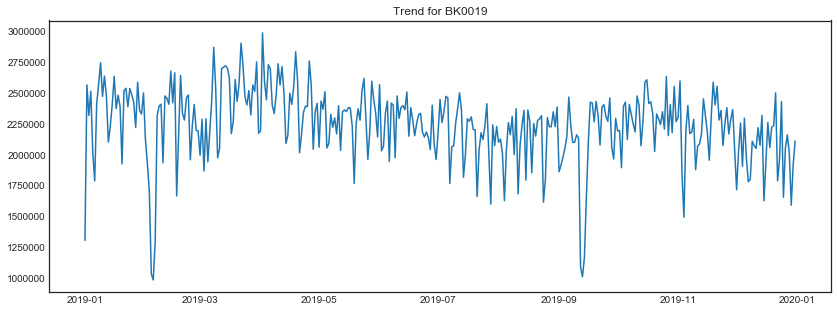

In [50]:
# vizualize the whole dataset in daily intervals
fig, ax = plt.subplots(figsize=(14,5))
plot_store_by_interval(ax, df2019, "BK0019", "D")


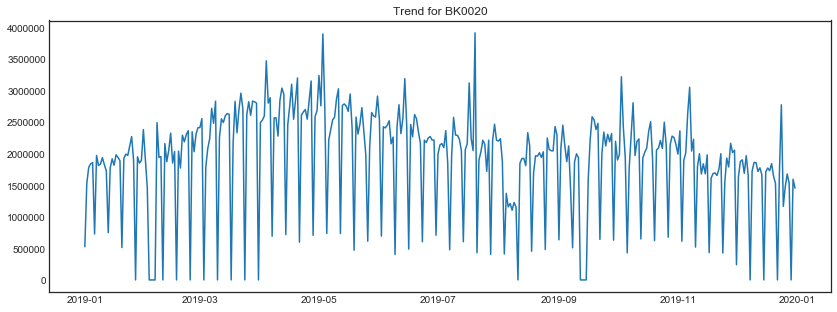

In [51]:
fig, ax = plt.subplots(figsize=(14,5))
plot_store_by_interval(ax, df2019, "BK0020", "D")

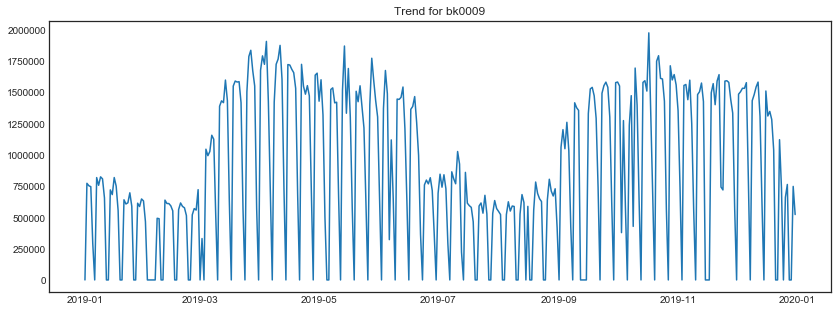

In [52]:
fig, ax = plt.subplots(figsize=(14,5))
plot_store_by_interval(ax, df2019, "bk0009", "D")

In [53]:
def weekly_average_series(df, STORE_CODE):
    """
    Calculates the average for each day of the week for one store. 
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    STORE_CODE: str
        Store ID number
    
    Returns
    =======
    Pandas Series
        Average for each day of the week
    
    """
    # get daily sales of store
    store_series = store_dataframe(df, "D")[STORE_CODE]
    # get count of each dayofweek in year
    c = Counter(store_series.index.dayofweek)
    count = np.array([x[1] for x in sorted(c.items())]) # convert to allow numpy broadcasting
    weekly_average = store_series.groupby(store_series.index.weekday).sum() / count
    return weekly_average

### Looking at weekly patterns
When looking the trend for a week, we can see that sales peak on Friday and are lowest on Sunday. This trend will also be slightly different depending on the location of the store.

[Text(0, 0, 'Mon'),
 Text(0, 0, 'Tues'),
 Text(0, 0, 'Wed'),
 Text(0, 0, 'Thurs'),
 Text(0, 0, 'Fri'),
 Text(0, 0, 'Sat'),
 Text(0, 0, 'Sun')]

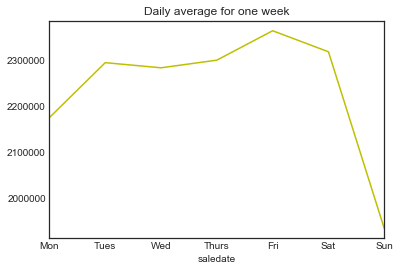

In [54]:
wk = weekly_average_series(df2019, "BK0019")
fig, ax = plt.subplots()
wk.plot(ax=ax, color='y')
ax.set_title("Daily average for one week")
ax.set_xticklabels(["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])

In [55]:
def weekly_average_dataframe(df):
    """
    Combines series from weekly_average_series() into one dataframe.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        Average for each day of the week
    
    """
    branches = df["branch"].unique() # prepare branch columns
    d = {branch:weekly_average_series(df, branch) for branch in branches} # dictionary of series
    weekly_df = pd.DataFrame.from_dict(d)
    return weekly_df

### Looking at daily patterns

The daily plot reveals yet another seasonality in the data. Every day the hourly sales look similar with a slight difference depending the day of the week.

In [57]:
def plot_series(ax, series, title):
    """ Plots a simple series for one store """
    ax.plot(series)
    ax.set_title(title)

def add_const(arr):
    return sm.add_constant(arr.reshape(-1, 1), prepend=False)

def fit_linear_trend(series):
    """ Fits a simple OLS model to the timeseries """
    X = add_const(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(store_df, STORE_CODE):
    """ Plots the OLS predicted values with actual values """
    series = store_df[STORE_CODE]
    linear_trend = fit_linear_trend(series)
    plot_series(ax, series, STORE_CODE)
    ax.plot(series.index.date, linear_trend)

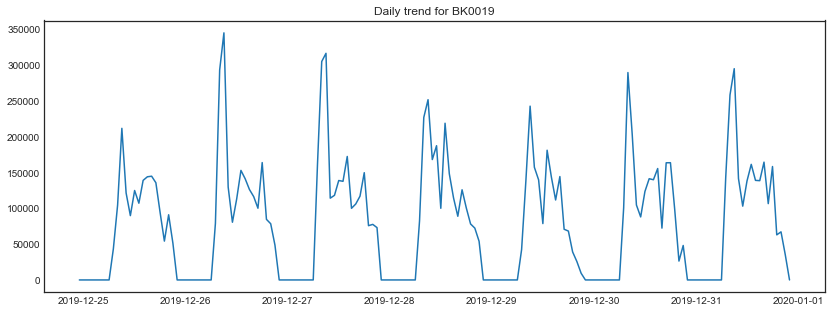

In [58]:
store_df_daily = store_dataframe(df2019, "H")
store_df_daily = store_df_daily.last("7D") # plot most recent day

fig, ax = plt.subplots(figsize=(14,5))
plot_series(ax, store_df_daily["BK0019"], "Daily trend for BK0019")

### Looking at the trend

For the next few plots, a simple OLS model was fit on the data to help visualize the direction of the trend throughout the year. 

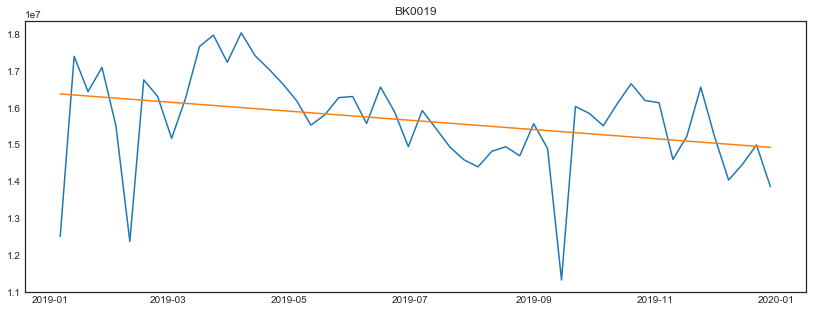

In [62]:
store_df_weekly = store_dataframe(df2019, "W")
fig, ax = plt.subplots(figsize=(14,5))
plot_linear_trend(store_df_weekly, "BK0019")

In [63]:
def fit_moving_average_trend(series, window=6):
    """ Fits a moving average to the timeseries """
    return series.rolling(window, center=True).mean()
    
def plot_ma_trend(ax, store_df, STORE_CODE, window=6):
    """ Plots moving average and actual sales together"""
    series = store_df[STORE_CODE]
    ma = fit_moving_average_trend(series, window)
    plot_series(ax, series, STORE_CODE)
    ax.plot(ma)

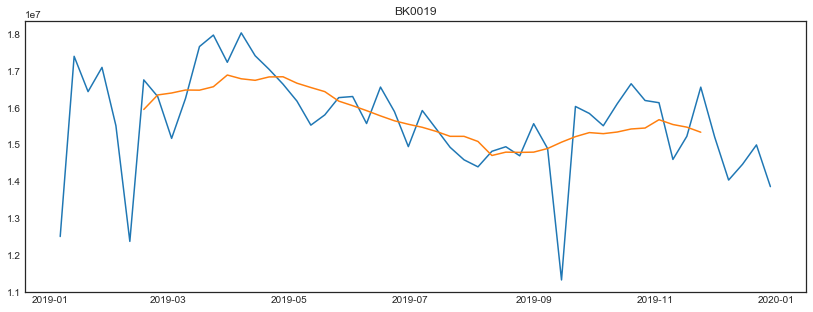

In [64]:
fig, ax = plt.subplots(figsize=(14,5))
plot_ma_trend(ax, store_df_weekly, "BK0019", window=12)
    

In [65]:
def plot_shared_yscales(axs, x, ys, titles):
    """ Plots all decomposed series in a stack"""
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))
        
def plot_seasonal_decomposition(axs, store_df, STORE_CODE, view, freq):
    """ Obtain seasonal decomposition series model """
    series = store_df[STORE_CODE].last(view)
    sd = sm.tsa.seasonal_decompose(series, freq=freq)
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", 
                         "Trend Component $T_t$", 
                         "Seasonal Component $S_t$",
                         "Residual Component $R_t$"])
    return sd

### Explore the seasonal patterns using seasonal decomposition

After applying tsa.seasonal_decomposition we can analyze the various components that make up the overall shape of the data. 
- **Trend:** the trend looks linear and almost horizontal. 
- **Seasonal:** mimics the daily trend that actually exists
- **Residual:** other than the gaps caused by closed store hours, the distribution looks normal/stationary

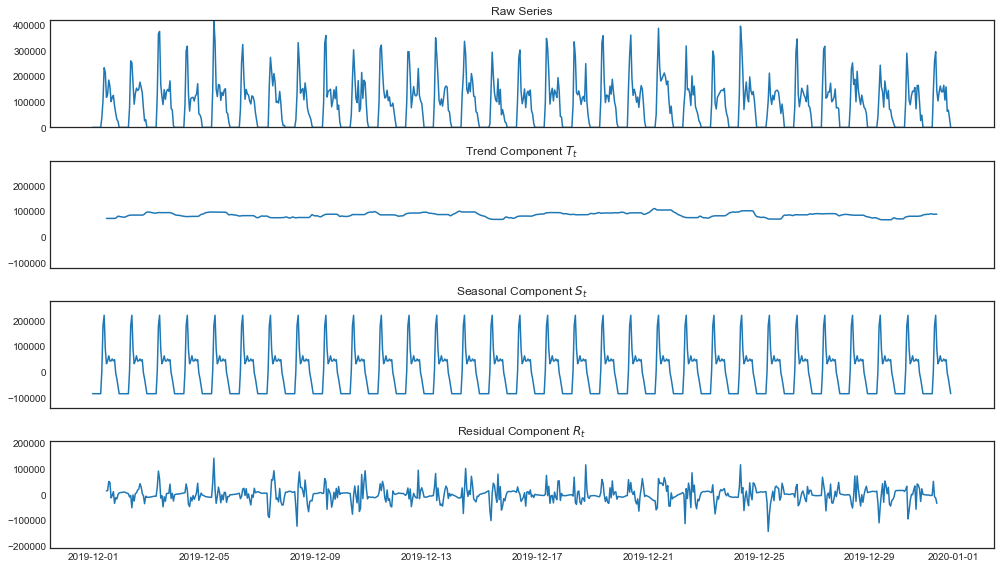

In [66]:
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
sd = plot_seasonal_decomposition(axs, 
                                 store_dataframe(df2019, "H"), 
                                 "BK0019",
                                 view="1M",
                                 freq=24)
plt.tight_layout()

In [67]:
# Augmented Dickey_fuller test to check if residuals are stationary
sd_resid = sd.resid.fillna(0)
test = sm.tsa.stattools.adfuller(sd_resid)
print("ADF p-value: {0:.7f}".format(test[1]))

ADF p-value: 0.0000000


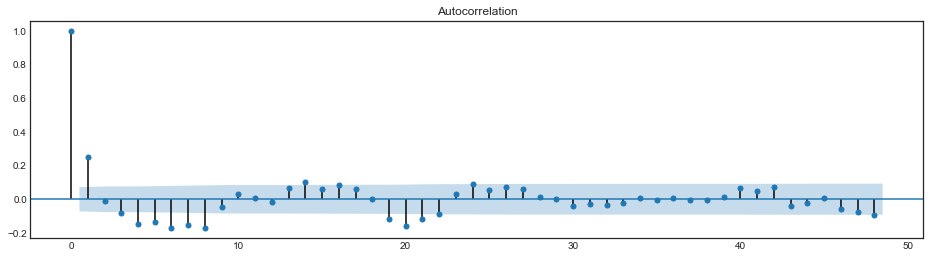

In [68]:
# Autocorrelation on residuals
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(sd_resid, lags=2*24, ax=ax)

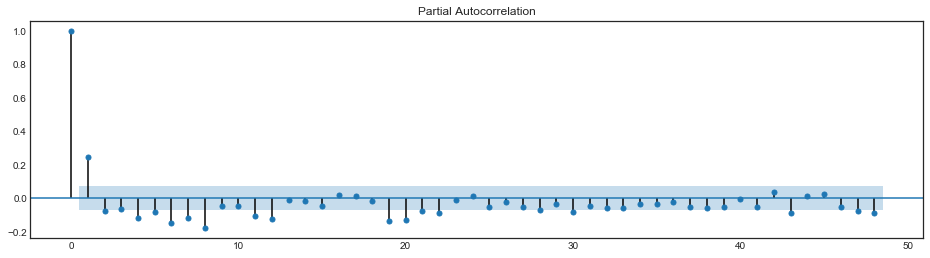

In [69]:
# Partial Autocorrelation on residuals
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(sd_resid, lags=2*24, ax=ax)

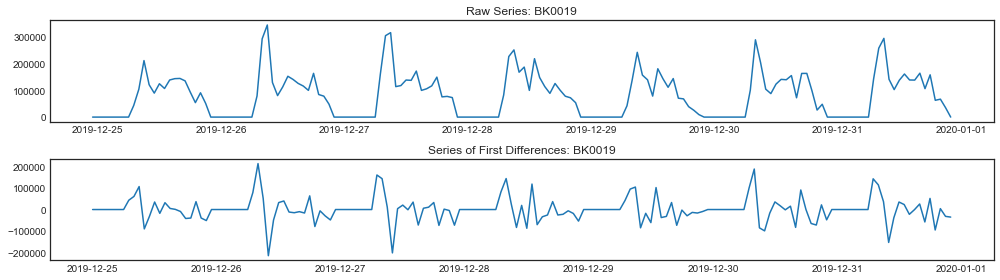

In [70]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(diff)
    axs[1].set_title("Series of First Differences: {}".format(title))


fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, store_df["BK0019"].last("7D"), 'BK0019')
fig.tight_layout()

In [72]:
# Augmented Dickey_fuller test
test1 = sm.tsa.stattools.adfuller(store_df["BK0019"].last("7D").diff().fillna(0))
print("ADF p-value: {0:.7f}".format(test1[1]))

ADF p-value: 0.0000000


### Test for autocorrelation and partial autocorrelation

In order to implement the ARIMA model we will need to check the acf and pacf plots. When taking the first difference of the timeseries there are periodical spikes which means there is seasonality. Since the extreme values doesn't seem to be random, the model will not perform well. 

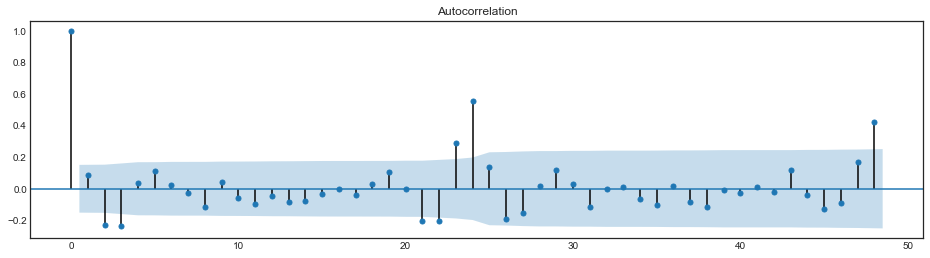

In [74]:
# Autocorrelation on diff
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(store_df["BK0019"].last("7D").diff().fillna(0), lags=2*24, ax=ax)

/Users/chulgyukim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



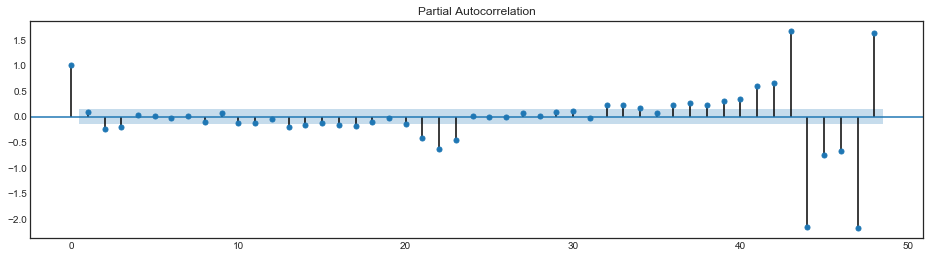

In [75]:
# Partial Autocorrelation on diff
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(store_df["BK0019"].last("7D").diff().fillna(0), lags=2*24, ax=ax)

### Basic modeling

A baseline model is created to compare performances of other models. This simple model will return the average sales for the hour we want to predict. In order to add weekly trend, a different hourly average will be used depending on the day of the week. First we implement a train-test split on the timeseries.


In [76]:
# make train_test_split
def tt_split(series, train_ratio=0.8):
    length_of_time_series = series.shape[0]
    train_idx = int(length_of_time_series*train_ratio)
    train_df = format_series_prophet(series.iloc[:train_idx])
    test_df = format_series_prophet(series.iloc[train_idx:])
    return train_df, test_df


In [81]:
 def format_series_prophet(series, most_recent=None):
    """
    Transform Panda Series into a dataframe that prophet will understand.
    
    Parameters
    =========
    series: Panda Series
        Timeseries data of one store
    most_recent: str
        Outputs only most recent time interval set
        (e.g. "3M" for last three months).
    
    Returns
    =======
    Pandas Dataframe
        Dataframe with two columns: "ds" (datetime) and "y" (value)
    """
    
    if most_recent:
        series = series.last(most_recent)
        
    df = series.reset_index()
    df.columns = ["ds", "y"]
    
    return df



In [82]:
## make TRAIN and TEST
store_by_hour = store_dataframe(df2019, "H")
train_df, test_df = tt_split(store_by_hour["BK0019"])

In [83]:
def generate_hourly_average(df, day_number):
    """
    Returns hourly averages for a given day of the week.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Time series with columns "ds" and "y"
    day_number: int
        0 - Monday
        6 - Sunday
    
    Returns
    =======
    Pandas DataFrame
    """
    
    mask = (df["ds"].dt.dayofweek==day_number)
    masked_df = df[mask]
    c = Counter(masked_df["ds"].dt.hour)
    count = np.array([x[1] for x in sorted(c.items())])
    hourly_average = masked_df.groupby(masked_df["ds"].dt.hour).sum()["y"] / count
    return hourly_average

def simple_model(train, test, plot=True):
    """
    A baseline model which takes predicts values using the average of the historical data.
    
    Parameters
    ==========
    train: Pandas DataFrame
        Training split of the timeseries with columns "ds" and "y"
    test: Pandas DataFrame
        Testing split of the timeseries with columns "ds" and "y"
    plot: boolean
        When True, function will also plot forecasts
    
    Returns
    =======
    Pandas DataFrame
        Returns test data set with "yhat" values appended
    """
    
    hourly_dict = {day_number:generate_hourly_average(train, day_number) 
                   for day_number in range(7)}
    
    test.loc[:,"yhat"] = (test.loc[:,"ds"].apply(lambda x: 
                                                 hourly_dict[x.dayofweek]
                                                 .iloc[x.hour]))
    
    if plot:
        fig, ax = plt.subplots()
        plotting_df = test.set_index("ds")
        ax.plot(plotting_df["yhat"], color="r")
        ax.plot(plotting_df["y"], alpha=0.3)
        
    return test#, hourly_dict

,ds,y,yhat
0,2019-10-19 23:00:00,0.0,0.000000
1,2019-10-20 00:00:00,0.0,0.000000
2,2019-10-20 01:00:00,0.0,0.000000
3,2019-10-20 02:00:00,0.0,0.000000
4,2019-10-20 03:00:00,0.0,0.000000
...,...,...,...
1747,2019-12-31 18:00:00,158000.0,156619.047619
1748,2019-12-31 19:00:00,62800.0,113891.666667
1749,2019-12-31 20:00:00,67000.0,64923.333333
1750,2019-12-31 21:00:00,35200.0,28308.333333


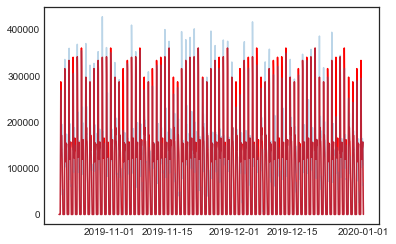

In [84]:
simple_model(train_df, test_df)

### Facebook's Prophet

In [85]:
from fbprophet import Prophet

In [86]:
 def format_series_prophet(series, most_recent=None):
    """
    Transform Panda Series into a dataframe that prophet will understand.
    
    Parameters
    =========
    series: Panda Series
        Timeseries data of one store
    most_recent: str
        Outputs only most recent time interval set
        (e.g. "3M" for last three months).
    
    Returns
    =======
    Pandas Dataframe
        Dataframe with two columns: "ds" (datetime) and "y" (value)
    """
    
    if most_recent:
        series = series.last(most_recent)
        
    df = series.reset_index()
    df.columns = ["ds", "y"]
    
    return df



In [87]:
def fb_prophet(df, store_hours=None):
    """
    Quick facebook prophet plot
    
    Parameters
    ==========
    df: Pandas DataFrame
        Must be have two columns: "ds", "y"
    store_hours: Tuple
        (open_time, close_time): 24-hour clock 
        
    Returns
    =======
    Matplotlib plot
        Returns forecast plot and components
    """
    
    if store_hours:
        operation_hours = (df["ds"].dt.hour>=store_hours[0]) & (df["ds"].dt.hour<=store_hours[1])
        df = df[operation_hours]
    m = Prophet(interval_width=0.95)
    m.fit(df)
    # how many days in the future you want to predict
    future = m.make_future_dataframe(periods=48, freq='H')
    if store_hours:
        future = future[operation_hours]
    forecast = m.predict(future)
    # plot forecast
    m.plot(forecast)
    m.plot_components(forecast)

In [ ]:
# first plot is visualization on one month
# m1 is the MCMC on monthly
# m2 is the full data

##### Visualizing Prophet
The first plot is trained on a month long period and is predicting for 48 horus ahead. In order to visualy see how Prophet is performing, only a small timeframe is plotted to declutter the space.

In [88]:
df_last_month = format_series_prophet(store_df["BK0019"], most_recent="1M")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


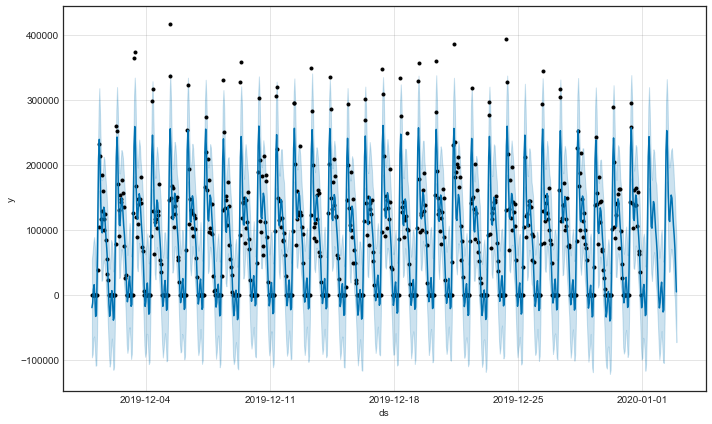

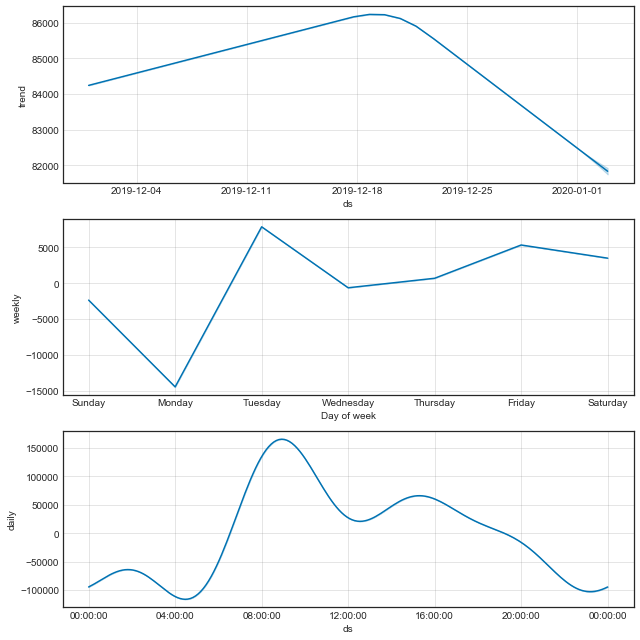

In [89]:
fb_prophet(df_last_month)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


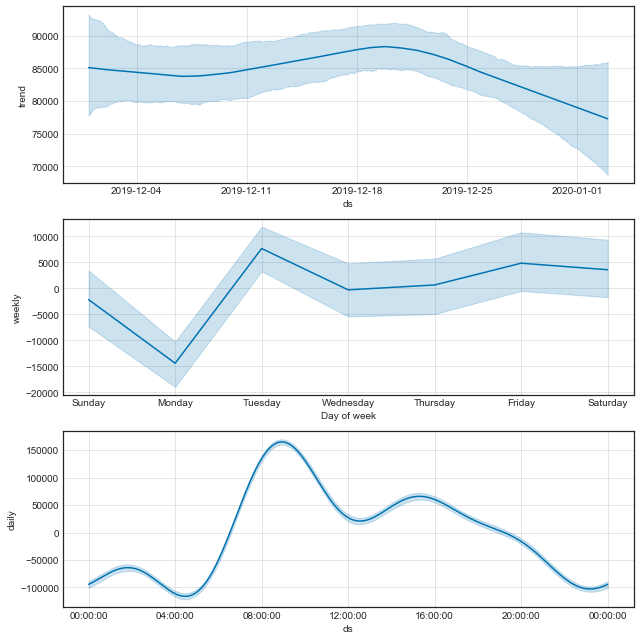

In [90]:
# using marcov chain to find posterior 
m1 = Prophet(mcmc_samples=100)
m1.fit(df_last_month)
future = m1.make_future_dataframe(periods=48, freq='H')
forecast = m1.predict(future)
fig = m1.plot_components(forecast)

##### Using the training data set
This time the model was trained on the full training set timeseries. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


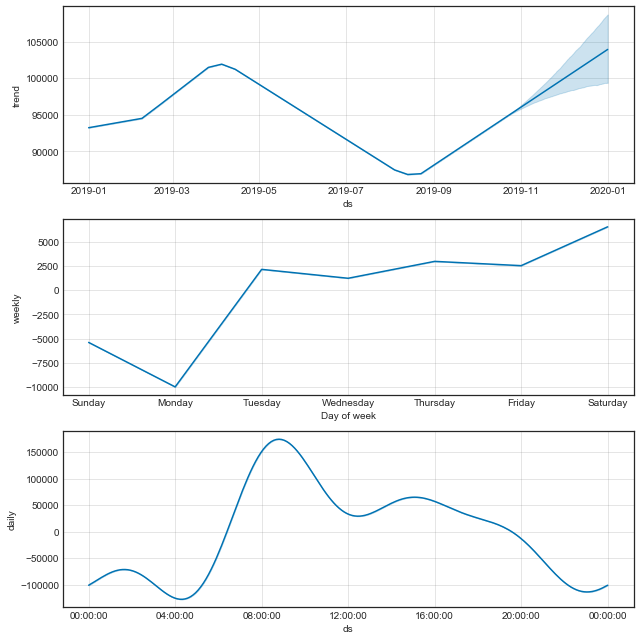

In [96]:
m2 = Prophet()
m2.fit(train_df)
future2 = m2.make_future_dataframe(periods=1752, freq='H')
forecast2 = m2.predict(future2)
fig = m2.plot_components(forecast2)


In [117]:
forecast2.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8756,2019-12-31 20:00:00,103904.285659,33923.630976,152554.189687,99350.580827,108685.163053,-11991.644485,-11991.644485,-11991.644485,-13471.100364,-13471.100364,-13471.100364,1479.455879,1479.455879,1479.455879,0.0,0.0,0.0,91912.641174
8757,2019-12-31 21:00:00,103909.671074,-1721.257136,107708.423385,99350.526345,108692.914132,-53133.743554,-53133.743554,-53133.743554,-54528.449884,-54528.449884,-54528.449884,1394.706330,1394.706330,1394.706330,0.0,0.0,0.0,50775.927519
8758,2019-12-31 22:00:00,103915.056489,-45869.744633,67730.815665,99350.471863,108700.665211,-94599.595301,-94599.595301,-94599.595301,-95922.402007,-95922.402007,-95922.402007,1322.806706,1322.806706,1322.806706,0.0,0.0,0.0,9315.461188


##### Cross validate using Prophet
Using the built in cross_validation function, we obtain a new dataframe with adjusted parameters.

In [100]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

df_cv = cross_validation(m2, horizon='2 days', period='14 days', initial='182 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-07-11 22:00:00 and 2019-10-17 22:00:00


In [101]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-11 23:00:00,-22566.543957,-79606.149987,31822.953984,0.0,2019-07-11 22:00:00
1,2019-07-12 00:00:00,-9045.659397,-69708.179965,47216.662120,0.0,2019-07-11 22:00:00
2,2019-07-12 01:00:00,15213.687334,-43579.263281,73917.697375,0.0,2019-07-11 22:00:00
3,2019-07-12 02:00:00,18920.655216,-38555.840750,78884.869332,0.0,2019-07-11 22:00:00
4,2019-07-12 03:00:00,-6859.762219,-63085.851195,51816.742813,0.0,2019-07-11 22:00:00
...,...,...,...,...,...,...
379,2019-10-19 18:00:00,118254.635847,60667.857948,175210.891044,57300.0,2019-10-17 22:00:00
380,2019-10-19 19:00:00,103880.319549,47554.146153,160501.504871,67300.0,2019-10-17 22:00:00
381,2019-10-19 20:00:00,77808.337686,22966.147413,135784.207477,62900.0,2019-10-17 22:00:00
382,2019-10-19 21:00:00,35973.198902,-19931.035136,93417.146494,38000.0,2019-10-17 22:00:00


In [118]:
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [103]:
df_p.head(2)

,horizon,mse,rmse,mae,coverage
0,05:00:00,2.367370e+08,15386.261035,14211.338578,1.0
1,06:00:00,4.101747e+08,20252.769706,17370.245074,1.0


##### Plotting the errors
Prophet will cross validate on every hour of the horizon timeframe, which allows it to obtain a rmse and mae for each hour we are predicting. There seems to be a bump in error roughly every 24 hours. 

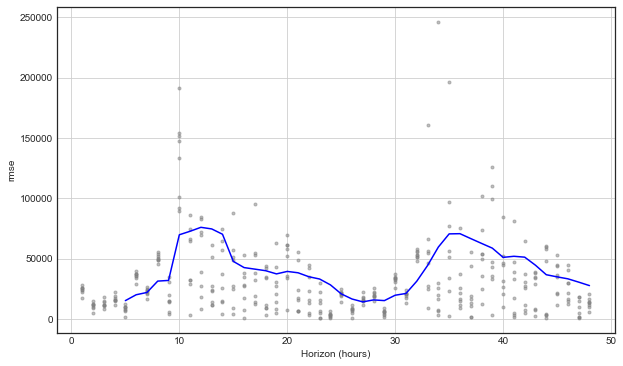

In [105]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


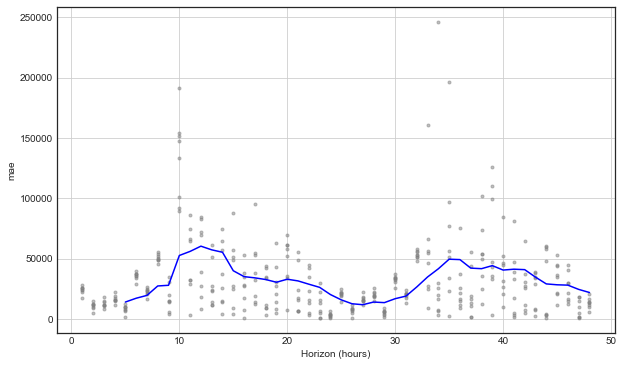

In [106]:
# plotting mean absolute error
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

#### Evaluate the model
In order to keep the evaluation consistent, a simple scoring function is used to calculate the error using the same algorithm for both models. From our basic implementation of Prophet we can see the simple_model performs slightly better. 

In [120]:
def simple_scorer(df):
    """calculate rmse and mae"""
    rmse = np.sqrt(((df["y"] - df["yhat"]) ** 2).mean())
    mae = np.abs(df["y"] - df["yhat"]).mean()
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

RMSE: 28114.280632477272
MAE: 16752.017816704596


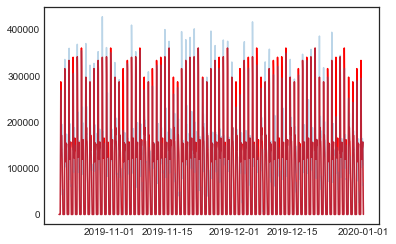

In [123]:
sm_df = simple_model(train_df, test_df)
simple_scorer(sm_df)

In [178]:
# format Prophet forecast so that scoring function can be implemented
def prep_forecast(forecast_df, test_df):
    prophet_p = test_df.copy()
    f = forecast_df[-(test_df.shape[0]):].copy()
    prophet_p["open_close"] = prophet_p["ds"].map(lambda x: 0 if (x.hour<7) | (x.hour>21) else 1)
    prophet_p["yhat"] = f["yhat"].values*prophet_p["open_close"]
    prophet_p.drop("open_close", axis=1, inplace=True)
    return prophet_p

In [179]:
prophet_p = prep_forecast(forecast2, test_df)
prophet_p.tail()

,ds,y,yhat
1747,2019-12-31 18:00:00,158000.0,130812.075193
1748,2019-12-31 19:00:00,62800.0,117203.290849
1749,2019-12-31 20:00:00,67000.0,91912.641174
1750,2019-12-31 21:00:00,35200.0,50775.927519
1751,2019-12-31 22:00:00,0.0,0.000000


In [134]:
simple_scorer(prophet_p)

RMSE: 40591.0280687828
MAE: 25186.0525902332


#### Experiment with 2 years of data

In [136]:
# use two years data to fit
## checking for yearly seasonal effect
df_2019 = pd.read_csv("../data/p_store_order2019.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})
df_2018 = pd.read_csv("../data/p_store_order2018.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})

In [ ]:
df_2019 = convert_dates(df_2019)
df_2018 = convert_dates(df_2018)

In [149]:
store_df_2019 = store_dataframe(df_2019, "H")
store_df_2018 = store_dataframe(df_2018, "H")

In [160]:
two_year_df = store_df_2018.append(store_df_2019, sort=True)

In [192]:
# train-test split
train_df3, test_df3 = tt_split(two_year_df["BK0019"])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


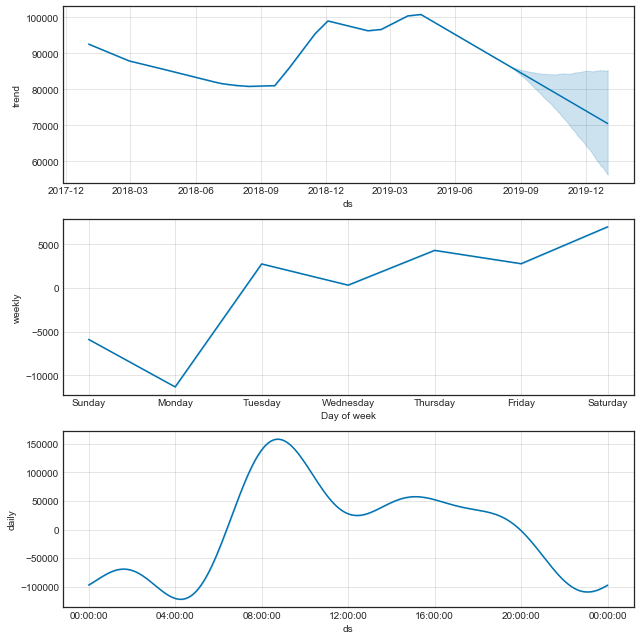

In [193]:
# implement Prophet model 3
m3 = Prophet()
m3.fit(train_df3)
future3 = m3.make_future_dataframe(periods=test_df3.shape[0], freq='H') # match length of test
forecast3 = m3.predict(future3)
fig = m3.plot_components(forecast3)

INFO:fbprophet:Making 29 forecasts with cutoffs between 2018-07-09 23:00:00 and 2019-08-05 23:00:00


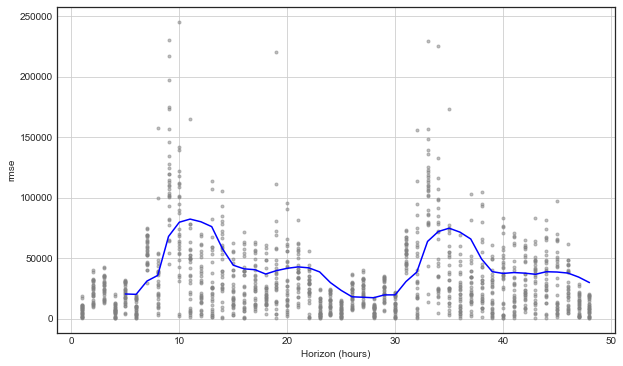

In [194]:
df_cv3 = cross_validation(m3, horizon='2 days', period='14 days', initial='182 days')
fig = plot_cross_validation_metric(df_cv3, metric='rmse')

In [180]:
# prep forecast data for test
prophet_p3 = prep_forecast(forecast3, test_df3)

In [191]:
test_df3

,ds,y
0,2018-10-20 01:00:00,0.0
1,2018-10-20 02:00:00,0.0
2,2018-10-20 03:00:00,0.0
3,2018-10-20 04:00:00,0.0
4,2018-10-20 05:00:00,0.0
...,...,...
1746,2018-12-31 19:00:00,85700.0
1747,2018-12-31 20:00:00,40500.0
1748,2018-12-31 21:00:00,12900.0
1749,2018-12-31 22:00:00,0.0


In [189]:
prophet_p3.tail()

,ds,y,yhat
1746,2018-12-31 19:00:00,85700.0,115979.867965
1747,2018-12-31 20:00:00,40500.0,90848.250211
1748,2018-12-31 21:00:00,12900.0,46806.464496
1749,2018-12-31 22:00:00,0.0,0.000000
1750,2018-12-31 23:00:00,0.0,-0.000000
